In [265]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import datetime
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import math
from numpy.linalg import svd

### Loading the initial dataset

In [3]:
path = os.getcwd() + '/../dataset/anonymized_dataset_for_ADM2017/'
print(path + 'student_log_{}.csv'.format(1))
log1 = pd.read_csv(path + 'student_log_{}.csv'.format(1))
initial_col_order = [col.lower() for col in list(log1.columns)]

data = pd.DataFrame()
for i in range(1, 10):
    student_log = pd.read_csv(path + 'student_log_{}.csv'.format(i))
    student_log.columns = [col.lower() for col in student_log]
    data = pd.concat([data, student_log], ignore_index=True)

# reorder everything with the original order, where student id is in the first column
data = data[initial_col_order]
data.shape
data.head()

/Users/yeldosbalgabekov/Desktop/Books and Schools/UoSouthampton/Data Mining/DataMining/Yeldos_Richa/../dataset/anonymized_dataset_for_ADM2017/student_log_1.csv


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,itest_id,sy assistments usage,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,...,confidence(off task),confidence(gaming),res_bored,res_concentrating,res_confused,res_frustrated,res_offtask,res_gaming,ln-1,ln
0,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.838710,0.008522,0.376427,0.320317,0.000000,0.0,0.785585,0.000264,0.13,0.0611904
1,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.600000,0.047821,0.156027,0.995053,0.887452,0.0,0.468252,0.001483,0.0611904,0.21351
2,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.600000,0.047821,0.156027,0.995053,0.887452,0.0,0.468252,0.001483,0.116,0.0333058
3,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.204082,0.343996,0.156027,0.744520,0.000000,0.0,0.108417,0.010665,0.116,0.0333058
4,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.204082,0.343996,0.156027,0.744520,0.000000,0.0,0.108417,0.010665,0.0333058,0.118386


### Transforming the initial dataset and loading Training Set

In [4]:
def to_float(x):
    try:
        if x.isdigit():
            return float(x)
    except:
        if x == '.':
            return 0
        return x

def series_types(series):
    types = []
    for i in set(series):
        if not type(i) in types:
            types.append(type(i))
    return(types)


data['sy assistments usage'] = data['sy assistments usage'].astype('category')
data['skill'] = data['skill'].astype('category')
data['problemtype'] = data['problemtype'].astype('category')
data['ln-1'] = data['ln-1'].apply(lambda x: to_float(x))
data['ln'] = data['ln'].apply(lambda x: to_float(x))
# data.memory_usage(deep=True)
# data.info(memory_usage='deep')

training = pd.read_csv(path + 'training_label.csv').drop(['AveCorrect'], axis=1)
training.columns = [col.lower() for col in training.columns]
training.shape

# merged data set with isSTEM
df = data.merge(training, on='itest_id', how="left")
#df.info()


### Filtering for the actions of the "training" students

In [5]:
actions = df[df.isstem.notnull()]
actions['skill'] = actions.skill.astype('category')
print("training set size: ", training.shape[0], "actions for # of students: ", len(actions.itest_id.unique()))
print("sample size useless for training: ", training.shape[0] - len(actions.itest_id.unique()))

# merged training data set
stem = actions[actions.isstem == 1]
nonstem = actions[actions.isstem == 0]

actions.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


training set size:  514 actions for # of students:  326
sample size useless for training:  188


,itest_id,sy assistments usage,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,...,res_concentrating,res_confused,res_frustrated,res_offtask,res_gaming,ln-1,ln,schoolid,mcas,isstem
1056,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.262675,0.060808,0.000000,0.889219,0.005797,0.271000,0.077899,2.0,34.0,0.0
1057,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.696486,0.000000,0.009561,0.108417,0.001483,0.077899,0.225856,2.0,34.0,0.0
1058,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.580763,0.000000,0.009561,0.108417,0.003940,0.225856,0.483008,2.0,34.0,0.0
1059,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.580763,0.000000,0.009561,0.108417,0.003940,0.483008,0.745290,2.0,34.0,0.0
1060,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.898073,0.000000,0.009561,0.468252,0.001483,0.745290,0.900994,2.0,34.0,0.0


### Testing the cases
Analysing other features

#### Creating temporary subset removing unnecessary data

In [52]:
cols = ['itest_id', 'skill', 'correct']
correctness = data[cols]
correctness['skill'] = correctness['skill'].astype('category')
correctness['skill'] = correctness['skill'].cat.codes
tmp1 = correctness.groupby(['itest_id', 'skill'], as_index=False).sum()
tmp2 = correctness.groupby(['itest_id', 'skill'], as_index=False).count()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [103]:
acc = pd.concat([tmp1, tmp2['correct']], axis=1)
acc.columns = ['itest_id', 'skill', 'correct', 'total']
acc['correctness'] = acc['correct'] / acc['total']
acc = acc.pivot(index='itest_id', columns='skill', values='correctness').fillna(0)
print(training.shape, acc.shape)
acc = acc.reset_index()
acc.head()



(514, 4) (1228, 101)


skill,itest_id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,8,0.0,0.800000,0.0,0.583333,1.0,1.0,1.0,0.666667,1.0,...,0.437500,1.000000,0.454545,0.0,0.392157,0.500000,0.200000,0.375000,0.375000,0.333333
1,35,0.0,0.684211,0.0,0.500000,0.0,0.0,0.0,0.200000,0.0,...,1.000000,0.500000,0.285714,0.0,0.333333,0.333333,0.142857,1.000000,0.000000,0.266667
2,39,0.0,0.588235,0.0,0.166667,0.0,0.0,0.0,1.000000,0.0,...,0.250000,0.500000,0.500000,0.0,0.000000,0.000000,1.000000,0.500000,0.000000,0.500000
3,64,0.0,0.363636,0.5,0.205882,0.0,0.0,0.0,0.285714,0.0,...,0.315789,0.230769,0.312500,1.0,0.288462,0.200000,0.250000,1.000000,0.428571,0.000000
4,77,0.0,0.000000,1.0,0.454545,0.0,0.0,0.0,1.000000,0.0,...,0.600000,0.257143,0.166667,0.0,0.800000,0.000000,1.000000,0.333333,0.000000,0.000000


In [157]:
tmp = training.merge(acc, on='itest_id')
n = tmp[tmp.isstem==1].shape[0]
tmp = pd.concat([tmp[tmp.isstem==0].sample(n), tmp[tmp.isstem==1]]).loc[:, 'isstem':]
tmp = tmp.reset_index()
tmp.head()

,index,isstem,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,155,0,0.0,0.000000,0.0,0.368421,0.0,0.0,0.0,0.000000,...,0.117647,0.166667,1.000000,0.0,0.210526,1.000000,0.500000,0.000000,0.294118,0.300000
1,4,0,0.0,0.363636,0.0,0.272727,0.0,0.0,0.0,0.200000,...,0.230769,0.181818,0.260870,0.0,0.666667,0.210526,0.300000,1.000000,0.000000,0.166667
2,71,0,0.0,0.666667,0.0,0.500000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.500000,0.166667,0.000000
3,355,0,0.0,0.274194,0.0,0.117647,0.0,0.0,0.0,1.000000,...,0.266667,0.333333,0.210526,0.0,0.315789,0.142857,0.176471,1.000000,0.250000,0.148148
4,342,0,0.0,0.750000,0.5,0.096774,0.0,0.0,0.0,0.166667,...,0.500000,0.333333,0.187500,0.0,0.294118,0.000000,0.250000,0.333333,0.222222,0.250000


In [245]:
def split(df):
    train, test = train_test_split(df, test_size=0.2)
    x_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    x_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
    return x_train, y_train, x_test, y_test
    
def classify(df, classifer):
    x_train, y_train, x_test, y_test = split(df)
    
    clf = classifer
    model = clf.fit(x_train, y_train)
    prediction = model.predict(x_test)
    return prediction
    return sum(prediction==y_test)/len(y_test)
    

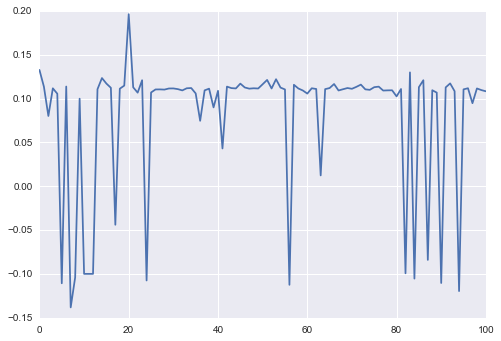

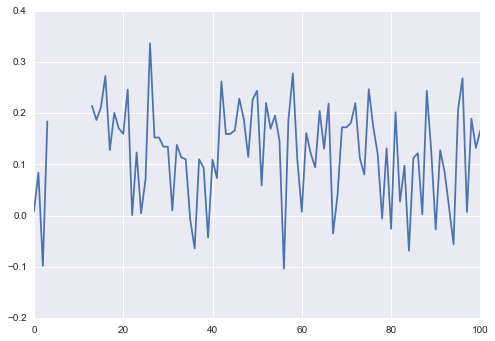

([<matplotlib.lines.Line2D at 0x11d854a90>], None)

In [264]:
a, b, c = svd(tmp.iloc[:, 2:])
svd_5 = pd.DataFrame(a[:, :5].dot(np.identity(len(b[:5])) + b[:5]).dot(c[:5, :]))
tr = pd.concat([tmp.iloc[:, :2], svd_5], axis=1)
corrs1 = []
for i in range(2,tr.shape[1]):
    corrs1.append(tr.isstem.corr(tr.iloc[:, i]))
plt.plot(corrs1), plt.show()
corrs2 = []
for i in range(2,tmp.shape[1]):
    corrs2.append(tmp.isstem.corr(tmp.iloc[:, i]))
plt.plot(corrs2), plt.show()


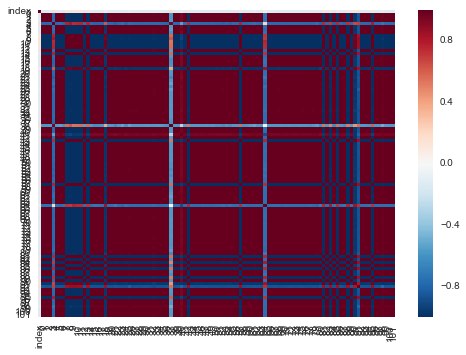

(<matplotlib.axes._subplots.AxesSubplot at 0x11b80e748>, None)

In [251]:
sns.heatmap(tr.corr()), plt.show()


In [9]:
def extract_feature(row):
    if row.accuracy > decision_boundary:
        return 1
    
def test_svm(df):
    train, test = train_test_split(df, test_size=0.2)
    train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
    test_X, test_y = test.iloc[:, 1:], test.iloc[:, 0]
    #w = inv(train_X.T.dot(train_X)).dot(train_X).dot(train_y)
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    clf = SVC(probability=True, kernel='linear')
    model = clf.fit(train_X, train_y)
    prediction = model.predict(test_X)
    prob = model.predict_proba(test_X)[:,1]
    
    accurate=[]
    fpr, tpr, thresholds = metrics.roc_curve(test_y, prediction)
    AUC = metrics.auc(fpr, tpr)
    RMSE = (metrics.mean_squared_error(test_y, prob)) ** 0.5
    accurate.append(AUC)
    mean_acc=np.mean(accurate)
    # print('prediction', prediction)
    print('threshodls: ', thresholds)
    print('Mean Acc: {}, RMSE: {}'.format(mean_acc, RMSE))
    comp = prediction == test_y
    return (sum(comp)/len(comp))

def test_mlp(df):
    train, test = train_test_split(df, test_size=0.2)
    train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
    test_X, test_y = test.iloc[:, 1:], test.iloc[:, 0]
    #w = inv(train_X.T.dot(train_X)).dot(train_X).dot(train_y)
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    clf = MLPClassifier()
    model = clf.fit(train_X, train_y)
    prediction = model.predict(test_X)
    prediction
    comp = prediction == test_y
    return (sum(comp)/len(comp))

# for m in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:
#     store = []
#     for i in range(100):
#         store.append(test_svm(df))
#     print("{} model: {}".format(m, sum(store)/len(store)))

